In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define the path to the dataset
dataset_path = '/kaggle/input/socofing/socofing'

# Define the target size for the images
target_size = (32, 32)

# Load images and labels
def load_images(dataset_path):
    images = []
    labels = []
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    # Resize image to target size
                    image = cv2.resize(image, target_size)
                    images.append(image)
                    labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images(dataset_path)

# Encode labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

print(f'Train set shape: {X_train.shape}, {y_train.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')


Train set shape: (4800, 32, 32), (4800,)
Test set shape: (1200, 32, 32), (1200,)


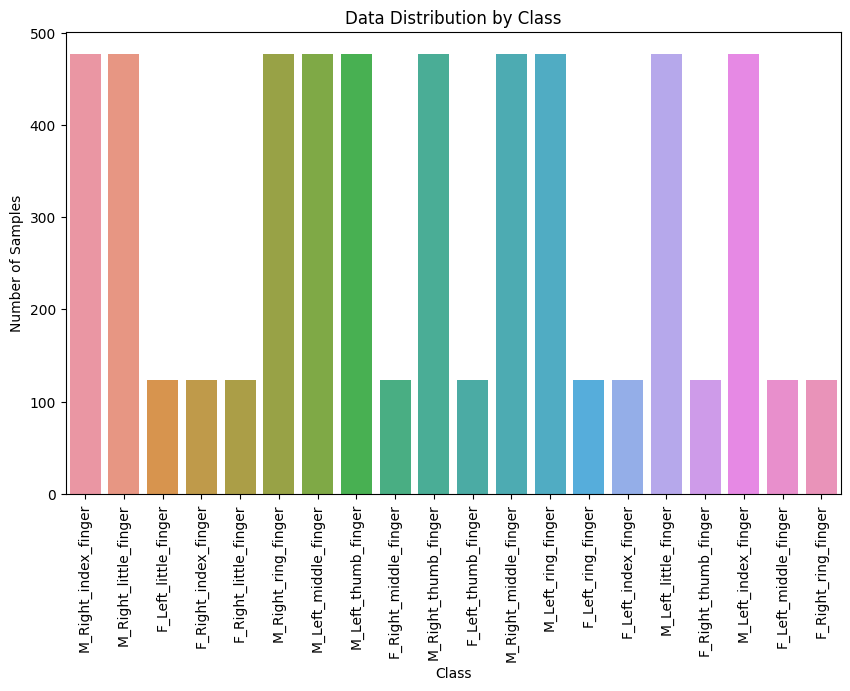

In [3]:
import seaborn as sns
# Plot the data distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=labels)
plt.title('Data Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.show() 

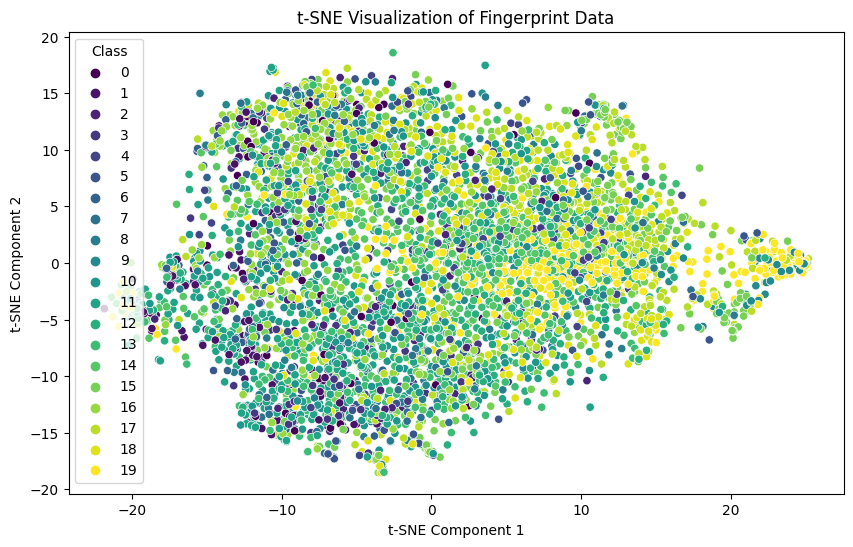

In [4]:
from sklearn.manifold import TSNE 
# Flatten images for t-SNE
X_flattened = X_train.reshape(X_train.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_flattened)

# Plot t-SNE result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette="viridis", legend="full")
plt.title('t-SNE Visualization of Fingerprint Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Class')
plt.show() 

In [5]:
!pip install tenseal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.7 MB/s eta 0:00:0000:0100:01


In [6]:
import tenseal as ts

# Function to encrypt images
def encrypt_images(images):
    encrypted_images = []
    # Increase the poly_modulus_degree to 16384
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=16384, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.generate_galois_keys()
    context.global_scale = 2**40

    for image in images:
        # Flatten the image
        flat_image = image.flatten().tolist()
        # Encrypt the image
        encrypted_image = ts.ckks_vector(context, flat_image)
        encrypted_images.append(encrypted_image)
    return encrypted_images, context

# Encrypt training and testing images
encrypted_X_train, train_context = encrypt_images(X_train)
encrypted_X_test, _ = encrypt_images(X_test) 

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Normalize the data
X_train = encrypted_X_train / 255.0
X_test = encrypted_X_test / 255.0

# Define the model
model = models.Sequential([
    layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test)) 

TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [ ]:
# Predict probabilities
y_pred_proba = model.predict(X_test)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

# Compute ROC curve
fpr = {}
tpr = {}
thresholds = {}

for i in range(len(np.unique(y_train))):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

# Plot ROC curve
plt.figure()
for i in range(len(np.unique(y_train))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

print(f'ROC AUC Score: {roc_auc}') 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import tenseal as ts
import tensorflow as tf
from tensorflow.keras import layers, models

# Predict probabilities
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)


# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_)
conf_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot training accuracy and loss
plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
import tenseal as ts
import numpy as np

# Encrypt a sample image
sample_image = X_train[0].flatten().tolist()
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=16384, coeff_mod_bit_sizes=[60, 40, 40, 60])
context.generate_galois_keys()
context.global_scale = 2**40
encrypted_sample = ts.ckks_vector(context, sample_image)

# Validate the data type
print(f"Type of encrypted data: {type(encrypted_sample)}")

# Perform an encrypted operation (e.g., addition)
encrypted_result = encrypted_sample + encrypted_sample

# Decrypt the result
decrypted_result = encrypted_result.decrypt()

# Reshape decrypted result to the original image shape
decrypted_image = np.array(decrypted_result).reshape(target_size)

# Compare the decrypted image to the original image
original_image = np.array(sample_image).reshape(target_size)

# Display the original and decrypted images to visually validate encryption/decryption
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Decrypted Image (after addition)")
plt.imshow(decrypted_image, cmap='gray')
plt.show() 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Compute precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 
#Confusion matrix
cm=confusion_matrix(y_preds1,y_test)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical',cmap=plt.cm.Purples) 
# Plot confusion matrix with horizontal x-axis labels
fig, ax = plt.subplots(figsize=(10, 10))
conf_disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.yticks(rotation=1)  # Rotate x-axis labels to horizontal
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_) 
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical',cmap=plt.cm.Purples)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your trained Keras model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)